# Imports

In [4]:
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

# Loading Data

In [23]:
with open("sample_dataset.csv") as file:
        bestand = pd.read_csv(file,sep=",")

# format the headers
bestand.columns = bestand.iloc[0]
bestand = bestand.drop(bestand.index[0])

# Convert columns to floats
headers_to_float = bestand.columns[2:]
bestand[headers_to_float] = bestand[headers_to_float].astype(float)

# change ref system to categorical var
bestand["SYSTEM"] = pd.factorize(bestand['SYSTEM'])[0]
bestand["SITE"] = pd.factorize(bestand['SITE'])[0]

# Transform and Scale Data

In [39]:
# The target variable
target = "Organic Carbon"

# Scale all numeric variables
bestand_numbers = bestand.iloc[:,3:]
bestand_numbers_values = StandardScaler().fit_transform(bestand_numbers.values)
bestand.iloc[:,3:] = bestand_numbers_values

# Move into X,y
X = bestand.drop(target, axis=1)
y = bestand[target]

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Categories and explanatory vars split
Categories = bestand.iloc[:,:3]
Explanatory_Variables = bestand.iloc[:,3:]

# Feature Selection

## PCA

Reduce from  (189, 24)  to  (189, 9) variables while retaining 90% variance
Explained variance: 0.9103485787743308


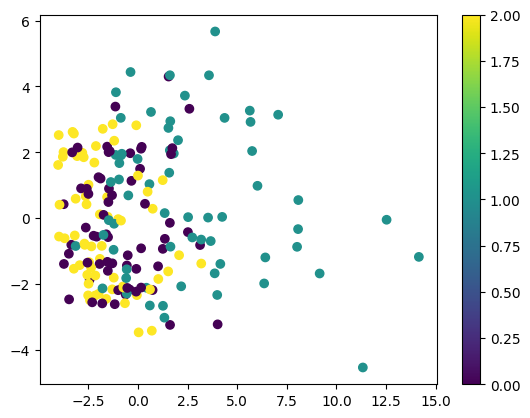

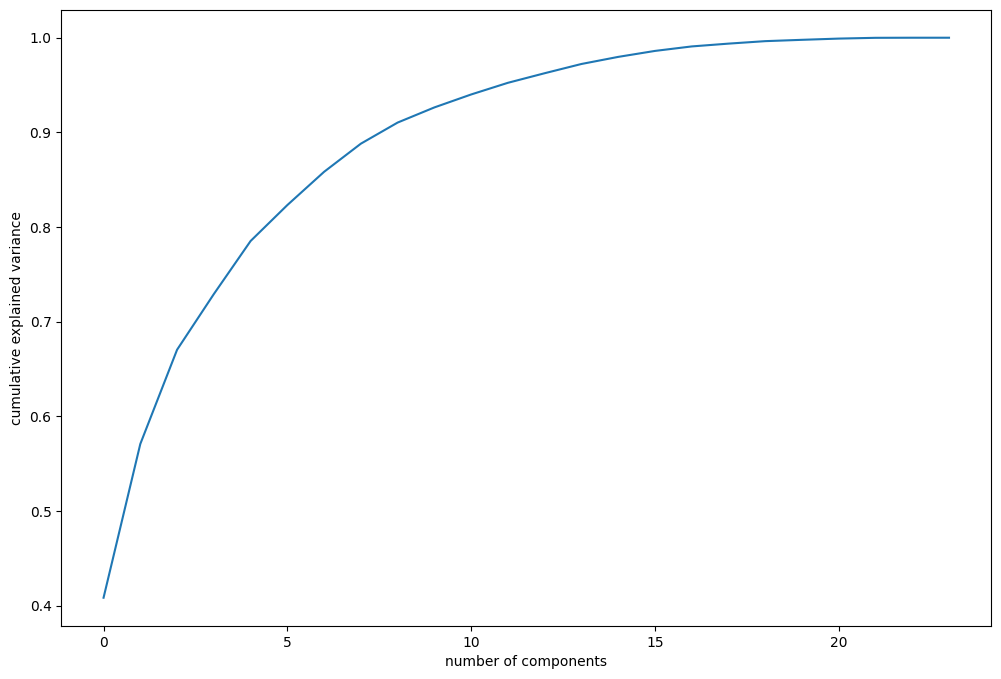

Meaning of the 2 components:
0.04 x SITE + -0.02 x SYSTEM + -0.00 x DEPT + 0.07 x Clay + 0.17 x Silt + -0.16 x Sand + 0.18 x pH + 0.25 x Aggregate Stability + 0.21 x Bulk Density + -0.11 x Corg_Clay + 0.26 x Dissolved Org. Carbon + 0.27 x Carbon-to-Nitrogen + 0.25 x Ergosterol + 0.10 x Microbial Carbon + 0.18 x Microbial Nitrogren + 0.28 x Microbial Phosphorus + 0.27 x Manosamine + 0.28 x Muramic Acid + 0.25 x Glucosamine + 0.22 x Sum Aminosugars + 0.23 x LAP + 0.24 x NAG + 0.24 x GLU + 0.13 x XYL 

-0.29 x SITE + -0.37 x SYSTEM + 0.43 x DEPT + -0.33 x Clay + 0.28 x Silt + -0.08 x Sand + 0.35 x pH + 0.16 x Aggregate Stability + 0.23 x Bulk Density + -0.01 x Corg_Clay + 0.03 x Dissolved Org. Carbon + -0.09 x Carbon-to-Nitrogen + -0.16 x Ergosterol + -0.01 x Microbial Carbon + 0.01 x Microbial Nitrogren + 0.06 x Microbial Phosphorus + 0.01 x Manosamine + 0.04 x Muramic Acid + -0.15 x Glucosamine + -0.05 x Sum Aminosugars + -0.19 x LAP + -0.19 x NAG + -0.18 x GLU + 0.17 x XYL 

-0.25 x SI

In [40]:
# Retain90% of variance
pca_soil = PCA(0.9)

# Fit and transform
pca_fit = PCA().fit(Explanatory_Variables)
pca_transform = pca_soil.fit_transform(Explanatory_Variables)
pca_transform_df = pd.DataFrame(pca_transform, index=Explanatory_Variables.index)
print("Reduce from ",Explanatory_Variables.shape," to ",pca_transform_df.shape, "variables while retaining 90% variance")
print("Explained variance:",np.sum(pca_soil.explained_variance_ratio_))

# Show a scatter plot of the first two components
target_pca = Categories["SYSTEM"]
sc = plt.scatter(pca_transform[:,0],pca_transform[:,1], c=target_pca)
plt.colorbar(sc)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

#Trying to decipher the meaning of the principal components
print("Meaning of the 2 components:")
for component in pca_fit.components_[0:4]:
    print(" + ".join("%.2f x %s" % (value, name)
                     for value, name in zip(component, X_train.columns)),"\n")


# Table of most important components
# get the index of the most important feature on EACH component
n_pcs = pca_soil.components_.shape[0]
most_important = [np.abs(pca_soil.components_[i]).argmax() for i in range(n_pcs)]
most_important_X_train = []
for i in range(len(pca_soil.components_)):
    val = most_important[i]
    most_important_X_train.append(pca_soil.components_[i][val])

# get the names
initial_feature_names = bestand.columns[2:]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
most_important_components_df = pd.DataFrame(dic.items())
most_important_components_df["X_train"] = most_important_X_train
print("Most important components:",most_important_components_df)

## F Regression